## Import Libraries

In [1]:
import jax
import jax.numpy as jnp
import immrax as irx
from scipy.interpolate import interp1d
import numpy as np
from scipy.io import loadmat


## Load Data

In [2]:
data = loadmat('export_for_verification/1.mat')
T_des = data['T_ref'][0]
U_des = data['U_ref']
Z_des = data['Z_ref']


## Define Helper Functions

In [3]:
def saturate_input(u):
    turtlebot_max_yaw_rate = 2.0 # rad/s
    turtlebot_max_accel = 2.0 # m/s^2

    min_rate = -turtlebot_max_yaw_rate
    max_rate = turtlebot_max_yaw_rate
    min_accel = -turtlebot_max_accel
    max_accel = turtlebot_max_accel


    mins = jnp.array([min_rate, min_accel])
    maxs = jnp.array([max_rate, max_accel])

    return jnp.clip(u, mins, maxs)


def rotation_matrix_2D(theta):
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                      [jnp.sin(theta), jnp.cos(theta)]])


def match_trajectories(T_des, *varargin):
    interp_mode = varargin[-1]
    interp_type = interp_mode if interp_mode is not None else 'linear'
    # T_des = varargin[0]
    T_des = np.array([T_des])
    # print(f"T_des: {T_des}")

    output = []
    out_idx = 1
    for idx in range(0,4,2):
        # get the current time and trajectory
        T = varargin[idx]
        # print('here')
        # print(T)
        Z = varargin[idx+1]
        
        # if T_des exceeds the bounds of T, pad T and Z accordingly
        if T_des[0] < T[0]:
            T = [T_des(0), T]
            Z = [Z[:,0], Z]
            # print('here1')
        
        if T_des[-1] > T[-1]:
            T = [T, T_des[-1]]
            Z = [Z, Z[:,-1]]
            # print('here2')
        

        if len(T) == 1 and T_des == T:
            # check if no interpolation is needed (this resolves a bug
            # where interp1 reinterprets the length of Z as a vector to be
            # interpolated, and throws an error because T and Z are not of
            # the same length)
            output[out_idx] = Z
        else:
            # call interp1 as usual
            x = T
            y = Z
            # print(f"x: {x}")
            # print(f"y: {y}")
            f = interp1d(x, y, kind=interp_type)
            x_new = T_des
            # print(f"x_new: {x_new}")
            y_new = f(x_new)
            # print(f"y_new: {y_new.shape}")

            output.append(y_new)
            # print(f"output: {output}")

    return output


In [4]:
def get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des):
    # define gains
    k_p = 9
    k_v = 12
    k_a = 1
    k_h = 1
    k_w = 1
    k_hp = 0
    
    # define parameters
    t_lkhd = 0.01
    t_fdbk = min(t_curr + t_lkhd, T_des[-1])
    # print(f"t_curr: {t_curr}")
    # print(f"t_lkhd: {t_lkhd}")
    # print(f"T_des[-1]: {T_des[-1]}")
    # print(f"t_fdbk: {t_fdbk}")

    # get current state
    p_cur = z_curr[0:2]
    h_cur = z_curr[2]
    v_cur = z_curr[3]
    # print(f"p_cur: {p_cur.shape}")

    # get desired state and inputs (assumes zero-order hold)
    # we are doing feedback about a desired trajectory
    [u_des, z_des] = match_trajectories(t_fdbk, T_des, U_des, T_des, Z_des, 'previous')
    p_des = z_des[0:2]
    v_des = z_des[3]
    h_des = z_des[2]
    # print(f"p_des: {p_des}")
    # print(f"v_des: {v_des}")
    # print(f"h_des: {h_des}")
    # print(f"u_des: {u_des}")
    # print(f"z_des: {z_des}")
    # print(f"z_des: {z_des.shape}")

    # get desired feedforward inputs
    w_des = u_des[0]
    a_des = u_des[1]


    # compute position error in heading direction
    # print(f"h_cur: {h_cur.shape}")
    # print(f"h_cur: {h_cur}")
    R = rotation_matrix_2D(h_cur[0])

    # print(f"R.shape: {R.shape}")
    x = p_des - p_cur
    # print(f"p_des: {p_des.shape}")
    # print(f"p_cur: {p_cur.shape}")
    # print(f"x: {x.shape}")


    p_err = R@x
    # print(f"p_err: {p_err.shape}")
    px_err = p_err[0]
    
    # compute heading relative to desired position
    hp_err = -jnp.atan2(p_err[1],p_err[0])


    # compute unsaturated inputs (they get saturated by the agent)
    w_out = k_h*(h_des - h_cur) + k_w*w_des + k_hp*hp_err
    a_out = k_p*px_err + k_v*(v_des - v_cur) + k_a*a_des
    U = jnp.array([w_out, a_out])
    # print(f"U: {U}")
    return U




### Now Test Everything We've Done So Far

In [5]:
# t_curr = 0
# z_curr = np.array([0, 0, 0, 0.5]).reshape(4,1)
# t_fdbk = 0.0102
# t_lkhd = 0.01
# U = get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des)

## Immrax

In [6]:
# All of the above code is used to define the function u_map
def u_map(t,z):
    # u = irx.interval(get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des).squeeze())
    u_des = get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des)
    u_sat = saturate_input(u_des.squeeze())
    return irx.interval(u_sat)

# w_map right now is empty, but ready for future implementation where we'd like to see noise
def w_map(t_curr, z_curr):
    return irx.interval([0.])

### Now test the function u_map

In [7]:
# t_curr = 0
# z_curr = np.array([0, 0, 0, 0.5]).reshape(4,1)
# print(u_map(t_curr, z_curr))

In [8]:
# Define our turtlebot system within the framework of immrax for reachability analysis
class Turtlebot (irx.System) :
    def __init__ (self) :
        self.evolution = 'continuous'
        self.xlen = 4
    def f (self, t, x, u, w) :
        px, py, h, v = x.ravel()
        u1, u2 = u.ravel()

        # calculate derivatives
        xd = v*jnp.cos(h)
        yd = v*jnp.sin(h)
        hd = u1
        vd = u2

        zd = jnp.array([xd, yd, hd, vd])
        return zd

In [9]:
olsys = Turtlebot() # creat an instance of the Turtlebot class
embsys = irx.natemb(olsys) # create an embedding system given the system dynamics of the Turtlebot

In [20]:
# Parameters for input calculation from RTD
t_curr = 0.
t_fdbk = 0.0102
U_des = U_des
Z_des = Z_des
T_des = T_des
# z_curr = np.array([0, 0, 0, 0.5]).reshape(4,1)
z_curr = jnp.array([0, 0, 0, 0.5])

# Parameters for Immrax
z_curr_int = irx.interval(z_curr.squeeze())
z_curr_int = irx.icentpert(z_curr.squeeze(), 0.01)
print(z_curr_int)
t0 = 0.
tf = T_des[-1]
dt = 0.1


[[(-0.01      , 0.01      )]
 [(-0.01      , 0.01      )]
 [(-0.01      , 0.01      )]
 [( 0.49000001, 0.50999999)]]


In [21]:
traj = embsys.compute_trajectory(
    t0, tf, irx.i2ut(z_curr_int), (u_map,w_map), 0.01, solver='rk45'
    )

In [22]:
tfinite = jnp.where(jnp.isfinite(traj.ts))
tt = traj.ts[tfinite]
xx = traj.ys[tfinite]
 
print(f"tt.shape: {tt.shape}")
print(f"xx.shape: {xx.shape}")

tt.shape: (86,)
xx.shape: (86, 8)


In [23]:
# xf = xx[-1]
# print(f"xf: {xf}")
# print(irx.ut2i(xf))

### Plot Everything

In [24]:
import matplotlib.pyplot as plt 
from immrax.utils import get_partitions_ut, run_times, draw_iarrays, gen_ics, draw_iarray


In [25]:
# robot desired location
x_des = 0.75
y_des = 0.5
z0 = z_curr
zx0 = z_curr[0]
zy0 = z_curr[1]
ZXs = Z_des[0]
ZYs = Z_des[1]

In [26]:
obstacle = loadmat('export_for_verification/obstacle.mat')
O = obstacle['O']
O_buf = obstacle['O_buf']
O_pts = obstacle['O_pts']


0
[[-0.01 -0.01 -0.01  0.49  0.01  0.01  0.01  0.51]]
[[-0.01 -0.01 -0.01  0.49] <= x <= [0.01 0.01 0.01 0.51]]
1
[[-5.0005889e-03 -1.0025612e-02  8.5266060e-05  5.0999999e-01
   1.5199999e-02  1.0078386e-02  2.0085266e-02  5.2999997e-01]]
[[-5.0005889e-03 -1.0025612e-02  8.5266060e-05  5.0999999e-01] <= x <= [0.0152     0.01007839 0.02008527 0.53      ]]
2
[[ 1.9774277e-04 -9.9987788e-03  1.0170532e-02  5.2999997e-01
   2.0599905e-02  1.0214229e-02  3.0170532e-02  5.4999995e-01]]
[[ 1.9774277e-04 -9.9987788e-03  1.0170532e-02  5.2999997e-01] <= x <= [0.02059991 0.01021423 0.03017053 0.54999995]]
3
[[ 0.00559437 -0.00991646  0.0202558   0.54999995  0.02619923  0.01041155
   0.0402558   0.56999993]]
[[ 0.00559437 -0.00991646  0.0202558   0.54999995] <= x <= [0.02619923 0.01041155 0.0402558  0.56999993]]
4
[[ 0.01118859 -0.00977464  0.03034106  0.56999993  0.03199735  0.01067436
   0.05034106  0.5899999 ]]
[[ 0.01118859 -0.00977464  0.03034106  0.56999993] <= x <= [0.03199735 0.01067436 

<Figure size 640x480 with 0 Axes>

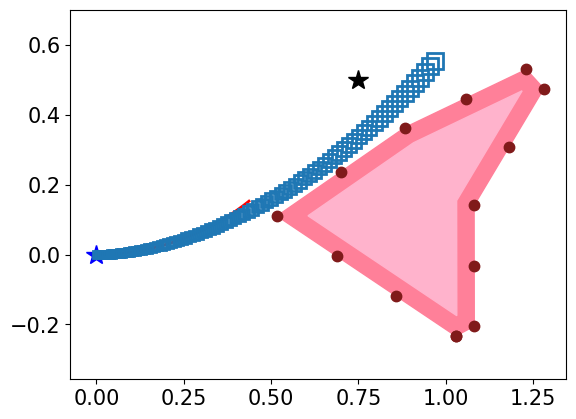

In [27]:
plt.figure(1) # Create a Figure
fig, ax = plt.subplots()

ax.axis('equal') # Set aspect ratio to be equal
ax.tick_params(axis='both', which='major', labelsize=15) # Adjust font size
ax.fill(O_buf[0], O_buf[1], color=[1, 0.5, 0.6]) # Plot the buffered obstacle
ax.fill(O[0], O[1], color=[1, 0.7, 0.8]) # Plot actual obstacle
ax.plot(O_pts[0,:], O_pts[1,:], '.', color=[0.5, 0.1, 0.1], markersize=15) # Plot discretized obstacle
ax.plot(x_des, y_des, 'k*', linewidth=2, markersize=15) # Plot the desired location of the robot
ax.plot(zx0, zy0, 'b*', linewidth=2, markersize=15) # Plot the desired location of the robot
ax.plot(ZXs, ZYs, 'r', linewidth=2, markersize=15) # Plot the desired location of the robot


tfinite = [i for i in range(len(tt))]
# tfinite = [i for i in range(1)]
# print(tfinite)
for t in tfinite:
    print(t)
    ut_t = jnp.array(xx[t]).reshape(1,-1)
    print(ut_t)
    boxes_t = [irx.ut2i(box) for box in ut_t] # Converted to intervals
    print(boxes_t)
    draw_iarrays(ax, boxes_t, zorder=2) # Draw the intervals on ax


plt.show() # Show the plot

In [28]:
import jax
import jax.numpy as jnp
import immrax as irx
from scipy.interpolate import interp1d
import numpy as np


# Load Data

In [29]:
# First string of numbers
string_of_numbers1 = """0	0.0100000000000000	0.0200000000000000	0.0300000000000000	0.0400000000000000	0.0500000000000000	0.0600000000000000	0.0700000000000000	0.0800000000000000	0.0900000000000000	0.100000000000000	0.110000000000000	0.120000000000000	0.130000000000000	0.140000000000000	0.150000000000000	0.160000000000000	0.170000000000000	0.180000000000000	0.190000000000000	0.200000000000000	0.210000000000000	0.220000000000000	0.230000000000000	0.240000000000000	0.250000000000000	0.260000000000000	0.270000000000000	0.280000000000000	0.290000000000000	0.300000000000000	0.310000000000000	0.320000000000000	0.330000000000000	0.340000000000000	0.350000000000000	0.360000000000000	0.370000000000000	0.380000000000000	0.390000000000000	0.400000000000000	0.410000000000000	0.420000000000000	0.430000000000000	0.440000000000000	0.450000000000000	0.460000000000000	0.470000000000000	0.480000000000000	0.490000000000000	0.500000000000000	0.510000000000000	0.520000000000000	0.530000000000000	0.540000000000000	0.550000000000000	0.560000000000000	0.570000000000000	0.580000000000000	0.590000000000000	0.600000000000000	0.610000000000000	0.620000000000000	0.630000000000000	0.640000000000000	0.650000000000000	0.660000000000000	0.670000000000000	0.680000000000000	0.690000000000000	0.700000000000000	0.710000000000000	0.720000000000000	0.730000000000000	0.740000000000000	0.750000000000000	0.760000000000000	0.770000000000000	0.780000000000000	0.790000000000000	0.800000000000000	0.810000000000000	0.820000000000000	0.830000000000000	0.840000000000000	0.850000000000000	0.860000000000000	0.870000000000000	0.880000000000000	0.890000000000000	0.900000000000000	0.910000000000000	0.920000000000000	0.924966217868738"""
numbers_list1 = [float(num) for num in string_of_numbers1.split()]
T_des = np.array(numbers_list1)
# T_des

In [30]:
# Second string of numbers
string_of_numbers2 = """0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.998821507441676	0.975317956678255	0.951814405914834	0.928310855151414	0.904807304387993	0.881303753624573	0.857800202861152	0.834296652097731	0.810793101334311	0.787289550570890	0.763785999807469	0.740282449044049	0.716778898280628	0.693275347517207	0.669771796753787	0.646268245990366	0.622764695226946	0.599261144463525	0.575757593700105	0.552254042936684	0.528750492173263	0.505246941409843	0.481743390646422	0.458239839883002	0.434736289119581	0.411232738356160	0.387729187592740	0.364225636829319	0.340722086065898	0.317218535302478	0.293714984539057	0.270211433775637	0.246707883012216	0.223204332248795	0.199700781485375	0.176197230721954	0.152693679958533	0.129190129195113	0.105686578431692	0.0821830276682717	0.0586794769048511	0.0351759261414305	0.0116723753780098	1.30470916089979e-16
0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-1.99999999999998	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000001	-2.00000000000000	-2.00000000000001	-1.99999999999998	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-1.99999999999998	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-2.00000000000000	-0.993243573747660	-0.993243573747660"""
numbers_list2 = [float(num) for num in string_of_numbers2.replace('\t', ' ').split()]
array2 = np.array(numbers_list2)
U_des = np.reshape(array2, (2, -1))

In [31]:
# Provided string of numbers
string_of_numbers = """0	0.00849918303679081	0.0169975181634386	0.0254941575568207	0.0339882537086859	0.0424789591760203	0.0509654266079682	0.0594468093079480	0.0679222612397034	0.0763909370273041	0.0848519919551454	0.0933045819679483	0.101747863670759	0.110180994539185	0.118603133499497	0.127013440051062	0.135411075045228	0.143795200769727	0.152164980948674	0.160519580742568	0.168858166748292	0.177179906999112	0.185483971036366	0.193769530658130	0.202035759064406	0.210281831427461	0.218506925119754	0.226710219713934	0.234890896982837	0.243048140899495	0.251181137637125	0.259289075575851	0.267371145968084	0.275426542460410	0.283454461204600	0.291454101297660	0.299424664781822	0.307365356644553	0.315275384818546	0.323153960181728	0.331000296557254	0.338813611109888	0.346593124484983	0.354338060314084	0.362047645884219	0.369721112147566	0.377357693721450	0.384956628888350	0.392517159595891	0.400038531456850	0.407498522189287	0.414804130010400	0.421930104510683	0.428862993399547	0.435593105727472	0.442114511886005	0.448425043607755	0.454526293966402	0.460423617376688	0.466125397168043	0.471632453255067	0.476945528179381	0.482066844473766	0.486998591250130	0.491742924199504	0.496301965592048	0.500677804277044	0.504872495682902	0.508888061517613	0.512726458831825	0.516389596786732	0.519879336612090	0.523197473708442	0.526345737647114	0.529325792170214	0.532139235190636	0.534787598792060	0.537272349228945	0.539594875770957	0.541756482850842	0.543758405912059	0.545601795973914	0.547287719389205	0.548817157844224	0.550191008358752	0.551410083286064	0.552475110312928	0.553386730464162	0.554145489106664	0.554751843607588	0.555206160457183	0.555508714695924	0.555659689914512	0.555678368621842
0	4.24461869547535e-05	0.000169780513202197	0.000381990275439303	0.000679054313017521	0.00106094298718883	0.00152761817889550	0.00207903332616446	0.00271513342451422	0.00343585502695483	0.00424112624398790	0.00513086674360661	0.00610498775129570	0.00716339207483689	0.00830597415282649	0.00953261994916218	0.0108432070709753	0.0122376047798127	0.0137156739916368	0.0152772672768253	0.0169222288601717	0.0186503946208847	0.0204615921081203	0.0223556406881802	0.0243323513453081	0.0263915268335097	0.0285329617293127	0.0307564424317674	0.0330617471624461	0.0354486459654436	0.0379169007073770	0.0404662650795313	0.0430964848000286	0.0458072974377108	0.0485984324744945	0.0514696114526746	0.0544205479749237	0.0574509477042930	0.0605605083642112	0.0637489197384855	0.0670158636713009	0.0703610142307180	0.0737840377388656	0.0772845925814027	0.0808623295057943	0.0845168916254594	0.0882479144197712	0.0920550257340570	0.0959378457795979	0.0998959871336294	0.103917585951966	0.107950164290515	0.111973984008135	0.115975531493815	0.119943387020916	0.123868224747166	0.127742812714663	0.131562012849877	0.135322780963643	0.139023800068878	0.142660144386104	0.146226971586318	0.149720337774974	0.153136445406753	0.156471643285566	0.159722426564549	0.162885436746068	0.165957461681716	0.168935435395117	0.171816420510530	0.174597619708580	0.177276373721386	0.179850150271288	0.182316544070850	0.184673276822857	0.186918197220319	0.189049280946466	0.191064630674753	0.192962467980877	0.194741128294789	0.196399071970265	0.197934872521900	0.199347216445435	0.200634903217757	0.201796845296898	0.202832068122036	0.203739710113496	0.204519021040451	0.205169354675220	0.205690175014491	0.206081053876122	0.206341670428767	0.206471811191878	0.206487916538666
0	0.00998821507441676	0.0199764301488335	0.0299646452232503	0.0399528602976670	0.0499410753720838	0.0599292904465005	0.0699175055209173	0.0799057205953341	0.0898939356697508	0.0998821507441676	0.109870365818584	0.119858580893001	0.129846795967418	0.139835011041835	0.149823226116251	0.159811441190668	0.169799656265085	0.179787871339502	0.189776086413918	0.199764301488335	0.209752516562752	0.219740731637169	0.229728946711585	0.239717161786002	0.249705376860419	0.259693591934836	0.269681807009252	0.279670022083669	0.289658237158086	0.299646452232503	0.309634667306919	0.319622882381336	0.329611097455753	0.339599312530170	0.349587527604586	0.359575742679003	0.369563957753420	0.379552172827837	0.389540387902253	0.399528602976670	0.409516818051087	0.419505033125504	0.429493248199920	0.439481463274337	0.449469678348754	0.459457893423171	0.469446108497587	0.479434323572004	0.489422538646421	0.499382152718670	0.509188682034150	0.518805861749822	0.528212992238013	0.537394324908284	0.546339062207427	0.555041357619467	0.563500315665659	0.571719991904493	0.579708435886781	0.587463813638673	0.594984155882930	0.602269462619554	0.609319733848543	0.616134969569898	0.622715169783618	0.629060334489705	0.635170463688157	0.641045557378976	0.646685615562160	0.652090638237709	0.657260625405625	0.662195577065906	0.666895493218553	0.671360373863566	0.675590219000945	0.679585028630689	0.683344802752800	0.686869541367276	0.690159244474118	0.693213912073325	0.696033544164899	0.698618140748838	0.700967701825143	0.703082227393814	0.704961717454851	0.706606172008253	0.708015591054021	0.709189974592155	0.710129322622655	0.710833635145521	0.711302912160752	0.711537153668349	0.711566137447936
0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.849932435737477	0.829932435737477	0.809932435737477	0.789932435737477	0.769932435737477	0.749932435737477	0.729932435737477	0.709932435737477	0.689932435737477	0.669932435737477	0.649932435737477	0.629932435737477	0.609932435737477	0.589932435737477	0.569932435737477	0.549932435737477	0.529932435737477	0.509932435737477	0.489932435737477	0.469932435737477	0.449932435737477	0.429932435737477	0.409932435737477	0.389932435737477	0.369932435737477	0.349932435737477	0.329932435737477	0.309932435737477	0.289932435737477	0.269932435737477	0.249932435737477	0.229932435737477	0.209932435737477	0.189932435737477	0.169932435737477	0.149932435737477	0.129932435737477	0.109932435737477	0.0899324357374768	0.0699324357374768	0.0499324357374767	0.0299324357374767	0.00993243573747671	1.11022302462516e-16"""
# Splitting the string into individual numbers and converting them to float
numbers_list = [float(num) for num in string_of_numbers.replace('\t', ' ').split()]

# Reshape the array into (4, 10)
Z_des = np.array(numbers_list).reshape(4, -1)

In [32]:
Z_des.shape

(4, 94)

# Define Useful Variables

In [33]:
t_curr = 0
z_curr = np.array([0, 0, 0, 0.5]).reshape(4,1)
t_fdbk = 0.0102
# x=5

# Define Helper Functions

In [34]:
def saturate_input(u):
    turtlebot_max_yaw_rate = 2.0 # rad/s
    turtlebot_max_accel = 2.0 # m/s^2

    min_rate = -turtlebot_max_yaw_rate
    max_rate = turtlebot_max_yaw_rate
    min_accel = -turtlebot_max_accel
    max_accel = turtlebot_max_accel


    mins = jnp.array([min_rate, min_accel])
    maxs = jnp.array([max_rate, max_accel])

    return jnp.clip(u, mins, maxs)

In [35]:
def rotation_matrix_2D(theta):
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                      [jnp.sin(theta), jnp.cos(theta)]])

In [36]:
def match_trajectories(T_des, *varargin):
    interp_mode = varargin[-1]
    interp_type = interp_mode if interp_mode is not None else 'linear'
    # T_des = varargin[0]
    T_des = np.array([T_des])
    # print(f"T_des: {T_des}")

    output = []
    out_idx = 1
    for idx in range(0,4,2):
        # get the current time and trajectory
        T = varargin[idx]
        # print('here')
        # print(T)
        Z = varargin[idx+1]
        
        # if T_des exceeds the bounds of T, pad T and Z accordingly
        if T_des[0] < T[0]:
            T = [T_des(0), T]
            Z = [Z[:,0], Z]
            # print('here1')
        
        if T_des[-1] > T[-1]:
            T = [T, T_des[-1]]
            Z = [Z, Z[:,-1]]
            # print('here2')
        

        if len(T) == 1 and T_des == T:
            # check if no interpolation is needed (this resolves a bug
            # where interp1 reinterprets the length of Z as a vector to be
            # interpolated, and throws an error because T and Z are not of
            # the same length)
            output[out_idx] = Z
        else:
            # call interp1 as usual
            x = T
            y = Z
            # print(f"x: {x}")
            # print(f"y: {y}")
            f = interp1d(x, y, kind=interp_type)
            x_new = T_des
            # print(f"x_new: {x_new}")
            y_new = f(x_new)
            # print(f"y_new: {y_new.shape}")

            output.append(y_new)
            # print(f"output: {output}")

    return output


In [37]:
[u_des, z_des] = match_trajectories(t_fdbk, T_des, U_des, T_des, Z_des, 'previous')
print(f"u_des: {u_des}\n")
print(f"z_des: {z_des}")


u_des: [[0.99882151]
 [0.        ]]

z_des: [[8.49918304e-03]
 [4.24461870e-05]
 [9.98821507e-03]
 [8.49932436e-01]]


In [38]:
def get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des):
    # define gains
    k_p = 9
    k_v = 12
    k_a = 1
    k_h = 1
    k_w = 1
    k_hp = 0
    
    # define parameters
    t_lkhd = 0.01
    t_fdbk = min(t_curr + t_lkhd, T_des[-1])
    # print(f"t_curr: {t_curr}")
    # print(f"t_lkhd: {t_lkhd}")
    # print(f"T_des[-1]: {T_des[-1]}")
    # print(f"t_fdbk: {t_fdbk}")

    # get current state
    p_cur = z_curr[0:2]
    h_cur = z_curr[2]
    v_cur = z_curr[3]
    # print(f"p_cur: {p_cur.shape}")

    # get desired state and inputs (assumes zero-order hold)
    # we are doing feedback about a desired trajectory
    [u_des, z_des] = match_trajectories(t_fdbk, T_des, U_des, T_des, Z_des, 'previous')
    p_des = z_des[0:2]
    v_des = z_des[3]
    h_des = z_des[2]
    # print(f"p_des: {p_des}")
    # print(f"v_des: {v_des}")
    # print(f"h_des: {h_des}")
    # print(f"u_des: {u_des}")
    # print(f"z_des: {z_des}")
    # print(f"z_des: {z_des.shape}")

    # get desired feedforward inputs
    w_des = u_des[0]
    a_des = u_des[1]


    # compute position error in heading direction
    # print(f"h_cur: {h_cur.shape}")
    # print(f"h_cur: {h_cur}")
    R = rotation_matrix_2D(h_cur[0])

    # print(f"R.shape: {R.shape}")
    x = p_des - p_cur
    # print(f"p_des: {p_des.shape}")
    # print(f"p_cur: {p_cur.shape}")
    # print(f"x: {x.shape}")


    p_err = R@x
    # print(f"p_err: {p_err.shape}")
    px_err = p_err[0]
    
    # compute heading relative to desired position
    hp_err = -jnp.atan2(p_err[1],p_err[0])


    # compute unsaturated inputs (they get saturated by the agent)
    w_out = k_h*(h_des - h_cur) + k_w*w_des + k_hp*hp_err
    a_out = k_p*px_err + k_v*(v_des - v_cur) + k_a*a_des
    U = jnp.array([w_out, a_out])
    # print(f"U: {U}")
    return U




In [39]:
U = get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des)

# Immrax

In [40]:
def u_map(t,z):
    # u = irx.interval(get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des).squeeze())
    u_des = get_control_inputs(t_curr, z_curr, T_des, U_des, Z_des)
    u_sat = saturate_input(u_des.squeeze())
    return irx.interval(u_sat)

In [41]:
print(u_map(t_curr, z_curr))

[[(1.00880969, 1.00880969)]
 [(2.        , 2.        )]]


In [42]:
def w_map(t_curr, z_curr):
    return irx.interval([0.])

In [43]:
class Turtlebot (irx.System) :
    def __init__ (self) :
        self.evolution = 'continuous'
        self.xlen = 4
    def f (self, t, x, u, w) :
        px, py, h, v = x.ravel()
        u1, u2 = u.ravel()

        # calculate derivatives
        xd = v*jnp.cos(h)
        yd = v*jnp.sin(h)
        hd = u1
        vd = u2

        zd = jnp.array([xd, yd, hd, vd])
        return zd

In [44]:
olsys = Turtlebot()
embsys = irx.natemb(olsys)

In [45]:
# Parameters for input calculation from RTD
t_curr = 0.
t_fdbk = 0.0102
U_des = U_des
Z_des = Z_des
T_des = T_des
z_curr = np.array([0, 0, 0, 0.5]).reshape(4,1)

# Parameters for Immrax
z_curr_int = irx.interval(z_curr.squeeze())
t0 = 0.
tf = T_des[-1]
dt = 0.1


In [46]:
traj = embsys.compute_trajectory(
    t0, tf, irx.i2ut(z_curr_int), (u_map,w_map), 0.01, solver='rk45'
    )

In [47]:
tfinite = jnp.where(jnp.isfinite(traj.ts))
tt = traj.ts[tfinite]
xx = traj.ys[tfinite]
 
print(f"tt.shape: {tt.shape}")
print(f"xx.shape: {xx.shape}")

tt.shape: (94,)
xx.shape: (94, 8)


In [48]:
initial_state = irx.ut2i(xx[0])
print(f"initial_state: {initial_state}\n")

final_state = irx.ut2i(xx[-1])
print(f"final_state: {final_state}")

initial_state: [[(0. , 0. )]
 [(0. , 0. )]
 [(0. , 0. )]
 [(0.5, 0.5)]]

final_state: [[(1.07637155, 1.07637155)]
 [(0.68786854, 0.68786854)]
 [(0.93311554, 0.93311554)]
 [(2.349931  , 2.349931  )]]


In [49]:
xx[0]

Array([0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0.5], dtype=float32)

In [50]:
xx[1][0:4]

Array([5.0999126e-03, 2.5892559e-05, 1.0088097e-02, 5.1999998e-01],      dtype=float32)

In [51]:
xx[10][0:4]

Array([0.05988979, 0.00319174, 0.10088094, 0.6999998 ], dtype=float32)

In [52]:
print(xx[:,0])

[0.         0.00509991 0.01039928 0.0158975  0.02159392 0.02748781
 0.03357838 0.0398648  0.04634616 0.0530215  0.05988979 0.06694995
 0.07420082 0.08164121 0.08926985 0.09708542 0.10508654 0.11327177
 0.12163959 0.13018844 0.13891672 0.14782275 0.15690479 0.16616105
 0.17558967 0.18518871 0.19495626 0.20489027 0.21498868 0.22524935
 0.2356701  0.24624869 0.2569828  0.2678701  0.27890813 0.29009452
 0.3014267  0.31290212 0.3245181  0.33627206 0.34816122 0.3601828
 0.37233397 0.38461193 0.3970137  0.4095363  0.4221767  0.4349318
 0.44779855 0.46077374 0.47385412 0.4870365  0.50031745 0.51369375
 0.5271619  0.5407185  0.5543601  0.5680831  0.58188397 0.5957591
 0.6097048  0.6237173  0.637793   0.65192807 0.6661187  0.680361
 0.69465107 0.70898503 0.7233589  0.7377687  0.7522103  0.76667976
 0.7811729  0.79568547 0.81021345 0.8247526  0.8392988  0.8538476
 0.8683947  0.88293594 0.89746684 0.911983   0.9264801  0.94095373
 0.9553993  0.9698124  0.9841886  0.99852335 1.012812   1.02705
 1.0

In [53]:
xx

Array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.00000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
       [5.09991264e-03, 2.58925593e-05, 1.00880973e-02, 5.19999981e-01,
        5.09991264e-03, 2.58925593e-05, 1.00880973e-02, 5.19999981e-01],
       [1.03992801e-02, 1.06257641e-04, 2.01761946e-02, 5.39999962e-01,
        1.03992801e-02, 1.06257641e-04, 2.01761946e-02, 5.39999962e-01],
       [1.58975050e-02, 2.45121744e-04, 3.02642919e-02, 5.59999943e-01,
        1.58975050e-02, 2.45121744e-04, 3.02642919e-02, 5.59999943e-01],
       [2.15939209e-02, 4.46504593e-04, 4.03523855e-02, 5.79999924e-01,
        2.15939209e-02, 4.46504593e-04, 4.03523855e-02, 5.79999924e-01],
       [2.74878051e-02, 7.14418304e-04, 5.04404791e-02, 5.99999905e-01,
        2.74878051e-02, 7.14418304e-04, 5.04404791e-02, 5.99999905e-01],
       [3.35783809e-02, 1.05286657e-03, 6.05285726e-02, 6.19999886e-01,
        3.35783809e-02, 1.05286657e-03, 6.05285726e-02, 6.

In [54]:
print(irx.interval(xx[:,0], xx[:,2]))

[[(0.        , 0.        )]
 [(0.00509991, 0.0100881 )]
 [(0.01039928, 0.02017619)]
 [(0.0158975 , 0.03026429)]
 [(0.02159392, 0.04035239)]
 [(0.02748781, 0.05044048)]
 [(0.03357838, 0.06052857)]
 [(0.0398648 , 0.07061666)]
 [(0.04634616, 0.08070476)]
 [(0.0530215 , 0.09079285)]
 [(0.05988979, 0.10088094)]
 [(0.06694995, 0.11096904)]
 [(0.07420082, 0.12105713)]
 [(0.08164121, 0.13114524)]
 [(0.08926985, 0.14123334)]
 [(0.09708542, 0.15132144)]
 [(0.10508654, 0.16140954)]
 [(0.11327177, 0.17149764)]
 [(0.12163959, 0.18158574)]
 [(0.13018844, 0.19167385)]
 [(0.13891672, 0.20176195)]
 [(0.14782275, 0.21185005)]
 [(0.15690479, 0.22193815)]
 [(0.16616105, 0.23202625)]
 [(0.17558967, 0.24211435)]
 [(0.18518871, 0.25220245)]
 [(0.19495626, 0.26229057)]
 [(0.20489027, 0.27237868)]
 [(0.21498868, 0.2824668 )]
 [(0.22524935, 0.29255491)]
 [(0.2356701 , 0.30264303)]
 [(0.24624869, 0.31273115)]
 [(0.2569828 , 0.32281926)]
 [(0.2678701 , 0.33290738)]
 [(0.27890813, 0.34299549)]
 [(0.29009452, 0.353